# 📊 Data Preparation & Exploratory Data Analysis (EDA)

**Assignment 2: Semi-Supervised & Self-Supervised Learning**

This notebook performs:
1. **Dataset Splitting**: 80% Train / 10% Validation / 10% Test
2. **Exploratory Data Analysis (EDA)**: Visualizations, class distributions, image statistics
3. **Data Quality Checks**: Missing labels, image properties, annotation statistics
4. **Save as Kaggle Dataset**: Output saved to `/kaggle/working/` for use as a new dataset

---

## 🚀 Kaggle Setup Instructions

1. **Upload your original dataset** to Kaggle as input
2. **Run this notebook** (all cells)
3. **Save output as dataset**: After running, click "Save Version" → "Quick Save"
4. **Create new dataset from output**: Go to notebook output → "New Dataset"
5. **Use the new dataset** in notebooks 02, 03, 04

---

## 1. Environment Setup

In [1]:
# NOTE: On Kaggle/Colab, most packages are pre-installed.
# Only install pyyaml if needed (usually already available)
# !pip install -q pyyaml

import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from collections import Counter, defaultdict
from tqdm import tqdm
import cv2
import warnings
warnings.filterwarnings('ignore')

# Try to import yaml, install if needed
try:
    import yaml
except ImportError:
    !pip install -q pyyaml
    import yaml

# Try to import seaborn
try:
    import seaborn as sns
    sns.set_palette('husl')
    HAS_SEABORN = True
except:
    HAS_SEABORN = False
    print("⚠️ Seaborn not available, using matplotlib only")

# Detect environment
IS_KAGGLE = os.path.exists('/kaggle/input')
IS_COLAB = 'google.colab' in str(get_ipython()) if 'get_ipython' in dir() else False

print(f"🖥️ Running on: {'Kaggle' if IS_KAGGLE else 'Colab' if IS_COLAB else 'Local'}")
print("✅ Libraries imported successfully!")

🖥️ Running on: Kaggle
✅ Libraries imported successfully!


## 2. Configuration & Paths

⚠️ **IMPORTANT**: Update `KAGGLE_DATASET_NAME` below to match your uploaded dataset name!

In [2]:
# ============================================
# 🔧 CONFIGURATION - MODIFY THESE PATHS
# ============================================

# ⬇️ CHANGE THIS to your Kaggle input dataset folder name ⬇️
KAGGLE_DATASET_NAME = '/kaggle/input/medical-v1i'  # <-- Update this!

if IS_KAGGLE:
    # Kaggle paths
    KAGGLE_INPUT_BASE = Path('/kaggle/input')
    
    # Find the dataset - list available inputs
    print("📁 Available input datasets:")
    for item in KAGGLE_INPUT_BASE.iterdir():
        print(f"   - {item.name}")
    
    # Try to find train folder
    ORIGINAL_DATASET_DIR = None
    
    # Check specified dataset name
    if (KAGGLE_INPUT_BASE / KAGGLE_DATASET_NAME / 'train' / 'images').exists():
        ORIGINAL_DATASET_DIR = KAGGLE_INPUT_BASE / KAGGLE_DATASET_NAME / 'train'
    elif (KAGGLE_INPUT_BASE / KAGGLE_DATASET_NAME / 'images').exists():
        ORIGINAL_DATASET_DIR = KAGGLE_INPUT_BASE / KAGGLE_DATASET_NAME
    else:
        # Auto-search for images folder
        for item in KAGGLE_INPUT_BASE.iterdir():
            if (item / 'train' / 'images').exists():
                ORIGINAL_DATASET_DIR = item / 'train'
                print(f"   ✅ Found dataset at: {ORIGINAL_DATASET_DIR}")
                break
            elif (item / 'images').exists():
                ORIGINAL_DATASET_DIR = item
                print(f"   ✅ Found dataset at: {ORIGINAL_DATASET_DIR}")
                break
    
    if ORIGINAL_DATASET_DIR is None:
        raise FileNotFoundError("❌ Could not find images folder. Please check your dataset structure.")
    
    # Output directory (Kaggle working directory - this gets saved)
    BASE_OUTPUT_DIR = Path('/kaggle/working/dataset')
    YAML_OUTPUT_PATH = Path('/kaggle/working/data.yaml')
    
elif IS_COLAB:
    # Colab paths - mount Google Drive first
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Update these paths for your Drive structure
    ORIGINAL_DATASET_DIR = Path('/content/drive/MyDrive/your_dataset/train')
    BASE_OUTPUT_DIR = Path('/content/dataset')
    YAML_OUTPUT_PATH = Path('/content/data.yaml')
    
else:
    # Local paths
    ORIGINAL_DATASET_DIR = Path('e:/EWU University/10th Semester/CSE475/Brain MRI/medical.v1i.yolov12/train')
    BASE_OUTPUT_DIR = Path('e:/EWU University/10th Semester/CSE475/Brain MRI/Assignment Final/dataset')
    YAML_OUTPUT_PATH = Path('e:/EWU University/10th Semester/CSE475/Brain MRI/Assignment Final/data.yaml')

IMAGES_DIR = ORIGINAL_DATASET_DIR / 'images'
LABELS_DIR = ORIGINAL_DATASET_DIR / 'labels'

# Verify paths exist
print(f"\n📁 Input Dataset: {ORIGINAL_DATASET_DIR}")
print(f"   Images folder exists: {IMAGES_DIR.exists()}")
print(f"   Labels folder exists: {LABELS_DIR.exists()}")
print(f"📁 Output Directory: {BASE_OUTPUT_DIR}")

# Data Split Ratios
TRAIN_RATIO = 0.80
VAL_RATIO = 0.10
TEST_RATIO = 0.10

# Random seed for reproducibility
RANDOM_SEED = 42

# Class names from original dataset
CLASS_NAMES = ['cct', 'ifc', 'uas']
NUM_CLASSES = len(CLASS_NAMES)

print(f"\n📊 Split Ratios: Train={TRAIN_RATIO}, Val={VAL_RATIO}, Test={TEST_RATIO}")
print(f"🏷️ Classes: {CLASS_NAMES}")

📁 Available input datasets:
   - medical-v1i

📁 Input Dataset: /kaggle/input/medical-v1i/train
   Images folder exists: True
   Labels folder exists: True
📁 Output Directory: /kaggle/working/dataset

📊 Split Ratios: Train=0.8, Val=0.1, Test=0.1
🏷️ Classes: ['cct', 'ifc', 'uas']


In [3]:
# Verify the dataset is accessible
if not IMAGES_DIR.exists():
    print("❌ ERROR: Images directory not found!")
    print("\n🔍 Let me search for image folders...")
    
    if IS_KAGGLE:
        for root, dirs, files in os.walk('/kaggle/input'):
            if 'images' in dirs:
                print(f"   Found images folder at: {root}/images")
            jpg_files = [f for f in files if f.endswith(('.jpg', '.png', '.jpeg'))]
            if len(jpg_files) > 10:
                print(f"   Found {len(jpg_files)} images in: {root}")
    
    raise FileNotFoundError("Please update KAGGLE_DATASET_NAME in the configuration cell above!")
else:
    print("✅ Dataset paths verified successfully!")
    print(f"   Found {len(list(IMAGES_DIR.glob('*')))} files in images folder")

✅ Dataset paths verified successfully!
   Found 2263 files in images folder


---
## 3. Exploratory Data Analysis (EDA)

### 3.1 Dataset Overview

In [4]:
# Gather all image files
image_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
all_images = [f for f in IMAGES_DIR.iterdir() if f.suffix.lower() in image_extensions]
all_labels = list(LABELS_DIR.glob('*.txt'))

print("="*60)
print("📈 DATASET OVERVIEW")
print("="*60)
print(f"Total Images: {len(all_images)}")
print(f"Total Label Files: {len(all_labels)}")
print(f"Images without labels: {len(all_images) - len(all_labels)}")
print("="*60)

📈 DATASET OVERVIEW
Total Images: 2263
Total Label Files: 2263
Images without labels: 0


### 3.2 Image Properties Analysis

In [5]:
# Analyze image properties (sample for speed)
widths, heights, aspects, file_sizes = [], [], [], []
channels_count = Counter()

sample_size = min(500, len(all_images))
print(f"🔍 Analyzing {sample_size} sample images...")

sample_images = random.sample(all_images, sample_size) if len(all_images) > sample_size else all_images

for img_path in tqdm(sample_images, desc="Sampling images"):
    try:
        img = Image.open(img_path)
        w, h = img.size
        widths.append(w)
        heights.append(h)
        aspects.append(w/h)
        file_sizes.append(img_path.stat().st_size / 1024)  # KB
        channels_count[img.mode] += 1
    except Exception as e:
        print(f"⚠️ Error reading {img_path.name}: {e}")

# Create summary DataFrame
image_stats = pd.DataFrame({
    'Metric': ['Width (px)', 'Height (px)', 'Aspect Ratio', 'File Size (KB)'],
    'Mean': [np.mean(widths), np.mean(heights), np.mean(aspects), np.mean(file_sizes)],
    'Std': [np.std(widths), np.std(heights), np.std(aspects), np.std(file_sizes)],
    'Min': [np.min(widths), np.min(heights), np.min(aspects), np.min(file_sizes)],
    'Max': [np.max(widths), np.max(heights), np.max(aspects), np.max(file_sizes)]
})

print("\n📊 IMAGE STATISTICS:")
print(image_stats.to_string(index=False))
print(f"\n🎨 Color Modes: {dict(channels_count)}")

🔍 Analyzing 500 sample images...


Sampling images: 100%|██████████| 500/500 [00:03<00:00, 138.19it/s]


📊 IMAGE STATISTICS:
        Metric       Mean      Std        Min        Max
    Width (px) 640.000000 0.000000 640.000000 640.000000
   Height (px) 640.000000 0.000000 640.000000 640.000000
  Aspect Ratio   1.000000 0.000000   1.000000   1.000000
File Size (KB)  34.903975 4.620224  20.135742  47.938477

🎨 Color Modes: {'RGB': 500}


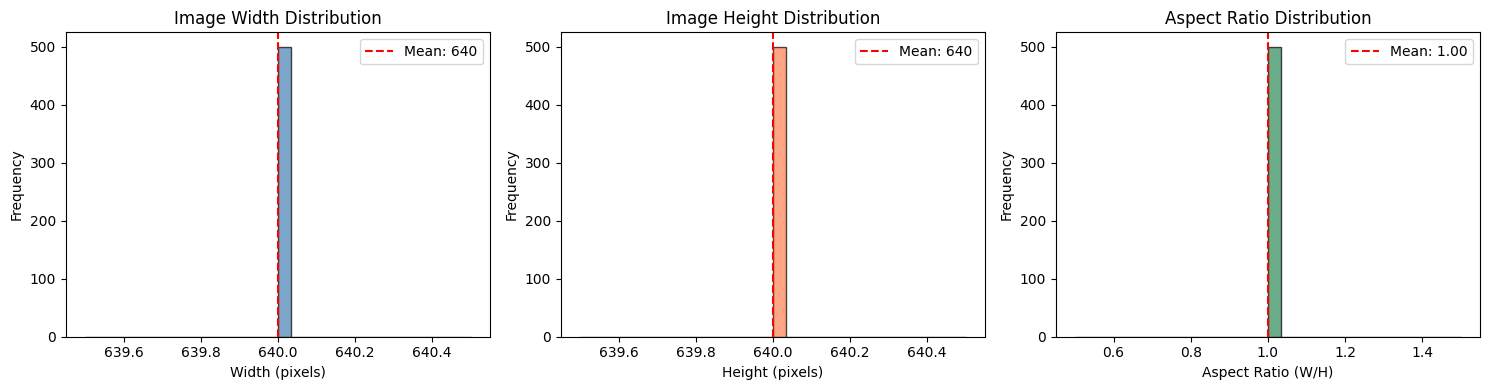

In [6]:
# Visualize image dimensions distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Width distribution
axes[0].hist(widths, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(widths), color='red', linestyle='--', label=f'Mean: {np.mean(widths):.0f}')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Image Width Distribution')
axes[0].legend()

# Height distribution
axes[1].hist(heights, bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(heights), color='red', linestyle='--', label=f'Mean: {np.mean(heights):.0f}')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Image Height Distribution')
axes[1].legend()

# Aspect ratio distribution
axes[2].hist(aspects, bins=30, color='seagreen', edgecolor='black', alpha=0.7)
axes[2].axvline(np.mean(aspects), color='red', linestyle='--', label=f'Mean: {np.mean(aspects):.2f}')
axes[2].set_xlabel('Aspect Ratio (W/H)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Aspect Ratio Distribution')
axes[2].legend()

plt.tight_layout()
plt.savefig('/kaggle/working/image_dimensions_analysis.png' if IS_KAGGLE else 'image_dimensions_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.3 Class Distribution Analysis

In [7]:
# Parse all label files and count classes
class_counts = Counter()
bbox_counts = []  # Number of bboxes per image
bbox_sizes = defaultdict(list)  # Bounding box sizes per class
images_per_class = defaultdict(set)  # Which images contain each class

print("🏷️ Parsing annotations...")
for label_path in tqdm(all_labels, desc="Reading labels"):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    bbox_counts.append(len(lines))
    
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 5:
            cls_id = int(parts[0])
            x, y, w, h = map(float, parts[1:5])
            class_counts[cls_id] += 1
            bbox_sizes[cls_id].append((w, h))
            images_per_class[cls_id].add(label_path.stem)

# Summary
print("\n" + "="*60)
print("🏷️ CLASS DISTRIBUTION")
print("="*60)
total_annotations = sum(class_counts.values())
for cls_id, count in sorted(class_counts.items()):
    cls_name = CLASS_NAMES[cls_id] if cls_id < len(CLASS_NAMES) else f'class_{cls_id}'
    pct = (count / total_annotations) * 100
    num_images = len(images_per_class[cls_id])
    print(f"  {cls_name}: {count} annotations ({pct:.1f}%) across {num_images} images")
print(f"\nTotal Annotations: {total_annotations}")
print(f"Avg Annotations/Image: {np.mean(bbox_counts):.2f}")
print("="*60)

🏷️ Parsing annotations...


Reading labels: 100%|██████████| 2263/2263 [00:14<00:00, 152.96it/s]


🏷️ CLASS DISTRIBUTION
  cct: 1245 annotations (51.1%) across 1171 images
  ifc: 936 annotations (38.4%) across 848 images
  uas: 256 annotations (10.5%) across 244 images

Total Annotations: 2437
Avg Annotations/Image: 1.08


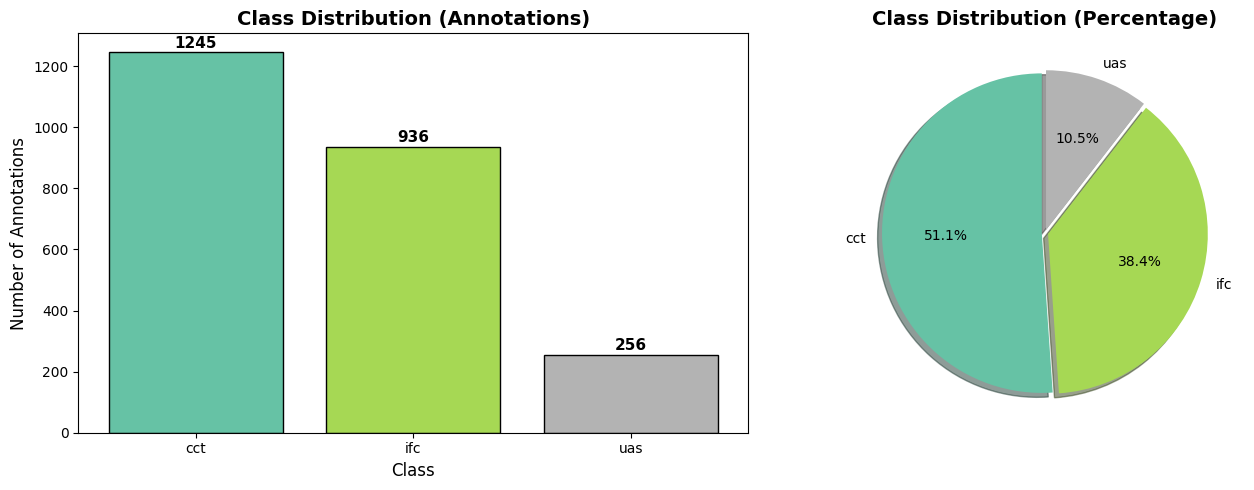

In [8]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart for class distribution
class_labels = [CLASS_NAMES[i] if i < len(CLASS_NAMES) else f'class_{i}' for i in sorted(class_counts.keys())]
class_values = [class_counts[i] for i in sorted(class_counts.keys())]
colors = plt.cm.Set2(np.linspace(0, 1, len(class_labels)))

bars = axes[0].bar(class_labels, class_values, color=colors, edgecolor='black')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Number of Annotations', fontsize=12)
axes[0].set_title('Class Distribution (Annotations)', fontsize=14, fontweight='bold')
for bar, val in zip(bars, class_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, str(val),
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie chart
axes[1].pie(class_values, labels=class_labels, autopct='%1.1f%%', colors=colors,
            explode=[0.02]*len(class_labels), shadow=True, startangle=90)
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('/kaggle/working/class_distribution.png' if IS_KAGGLE else 'class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.4 Sample Images Visualization

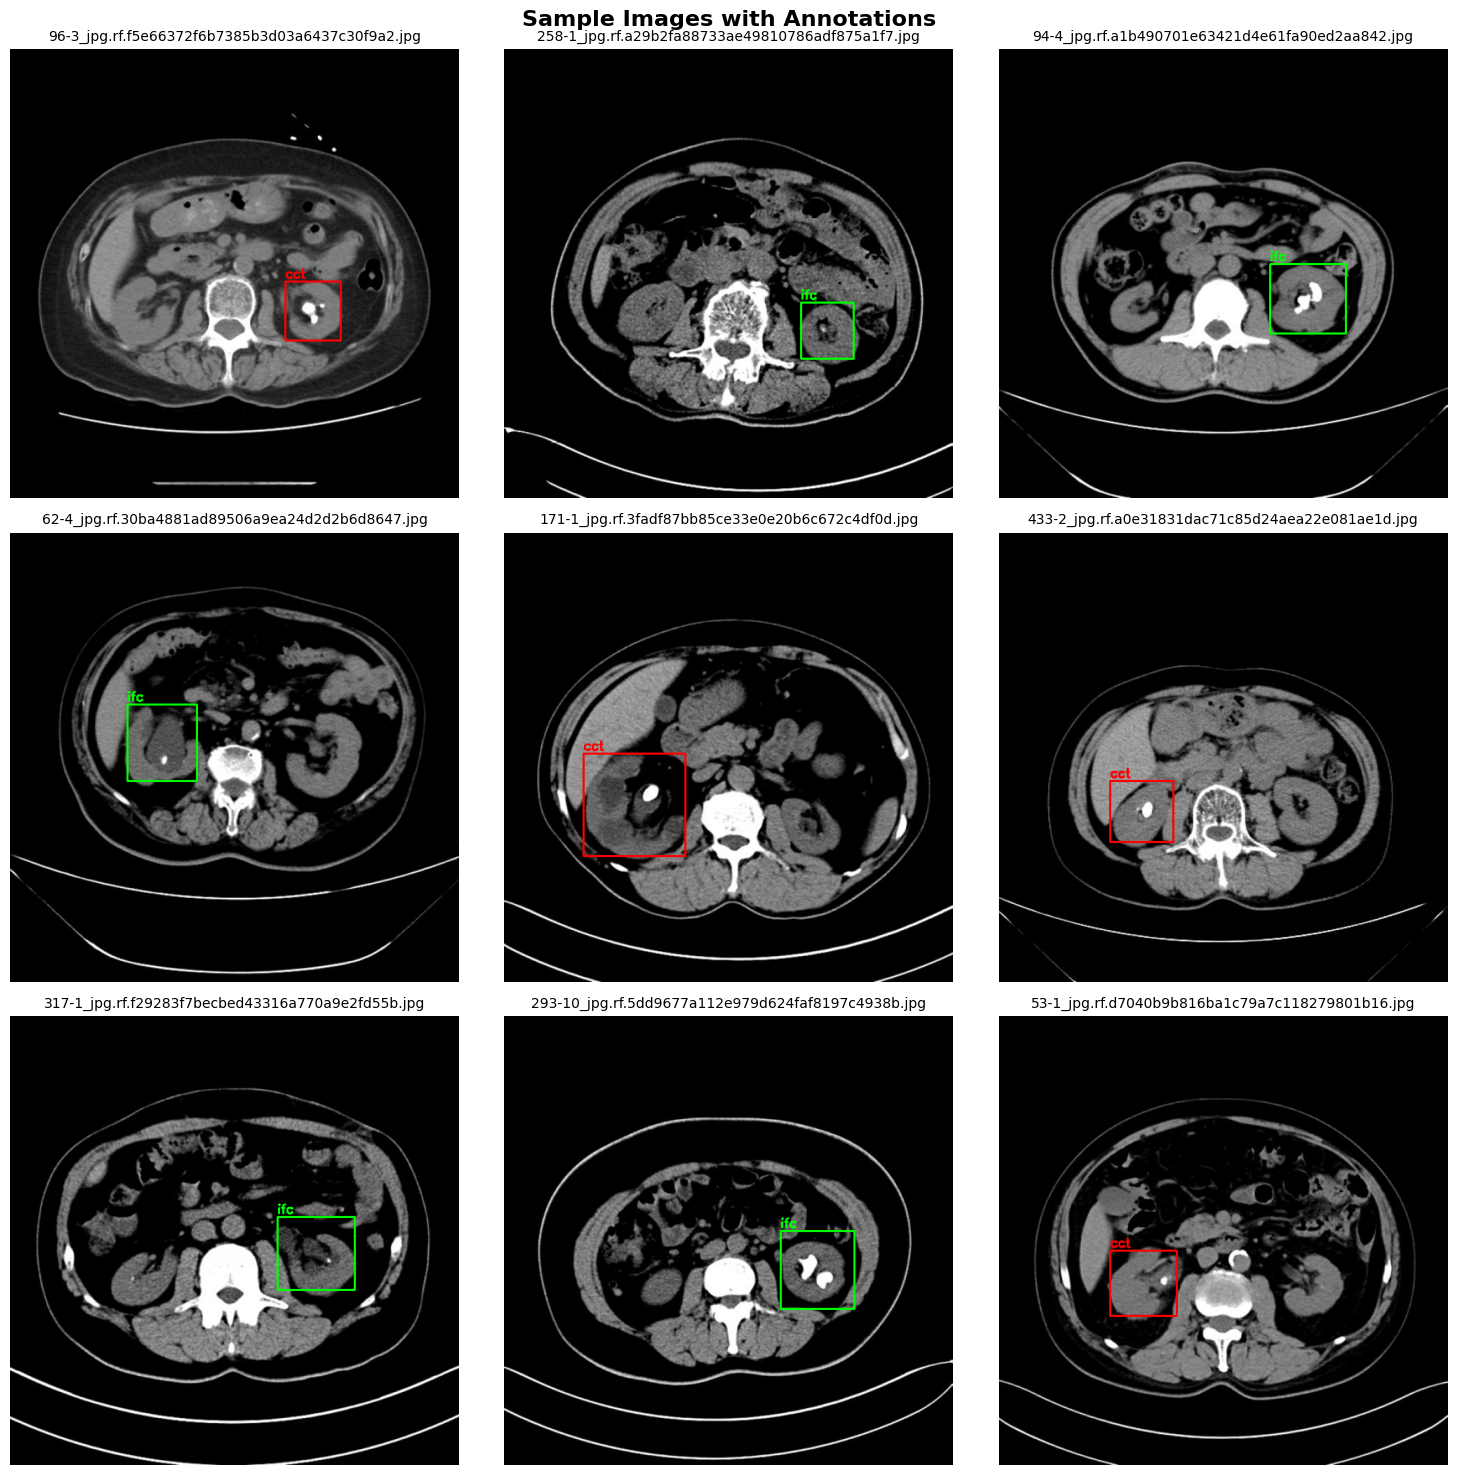

In [9]:
def draw_boxes(image_path, label_path, class_names):
    """Draw bounding boxes on image."""
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]
    
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) >= 5:
                    cls_id = int(parts[0])
                    cx, cy, bw, bh = map(float, parts[1:5])
                    
                    # Convert YOLO format to pixel coordinates
                    x1 = int((cx - bw/2) * w)
                    y1 = int((cy - bh/2) * h)
                    x2 = int((cx + bw/2) * w)
                    y2 = int((cy + bh/2) * h)
                    
                    color = colors[cls_id % len(colors)]
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                    
                    label = class_names[cls_id] if cls_id < len(class_names) else f'cls_{cls_id}'
                    cv2.putText(img, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    return img

# Display sample images with annotations
sample_images = random.sample(all_images, min(9, len(all_images)))

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, img_path in enumerate(sample_images):
    label_path = LABELS_DIR / (img_path.stem + '.txt')
    img_with_boxes = draw_boxes(img_path, label_path, CLASS_NAMES)
    axes[idx].imshow(img_with_boxes)
    axes[idx].set_title(img_path.name, fontsize=10)
    axes[idx].axis('off')

plt.suptitle('Sample Images with Annotations', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('/kaggle/working/sample_images.png' if IS_KAGGLE else 'sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4. Data Splitting (80/10/10)

In [10]:
# Create output directories
for split in ['train', 'valid', 'test']:
    (BASE_OUTPUT_DIR / split / 'images').mkdir(parents=True, exist_ok=True)
    (BASE_OUTPUT_DIR / split / 'labels').mkdir(parents=True, exist_ok=True)

print(f"✅ Created directory structure at {BASE_OUTPUT_DIR}")

# Shuffle and split
random.seed(RANDOM_SEED)
shuffled_images = all_images.copy()
random.shuffle(shuffled_images)

total = len(shuffled_images)
train_end = int(total * TRAIN_RATIO)
val_end = int(total * (TRAIN_RATIO + VAL_RATIO))

train_files = shuffled_images[:train_end]
val_files = shuffled_images[train_end:val_end]
test_files = shuffled_images[val_end:]

print(f"\n📊 SPLIT SUMMARY:")
print(f"  Training:   {len(train_files)} images ({len(train_files)/total*100:.1f}%)")
print(f"  Validation: {len(val_files)} images ({len(val_files)/total*100:.1f}%)")
print(f"  Testing:    {len(test_files)} images ({len(test_files)/total*100:.1f}%)")
print(f"  Total:      {total} images")

✅ Created directory structure at /kaggle/working/dataset

📊 SPLIT SUMMARY:
  Training:   1810 images (80.0%)
  Validation: 226 images (10.0%)
  Testing:    227 images (10.0%)
  Total:      2263 images


In [11]:
def copy_dataset(files, split_name, source_img_dir, source_lbl_dir, output_dir):
    """Copy images and labels to the split directory."""
    copied, missing_labels = 0, 0
    
    for img_path in tqdm(files, desc=f"Copying {split_name}"):
        # Copy image
        dest_img = output_dir / split_name / 'images' / img_path.name
        shutil.copy2(img_path, dest_img)
        
        # Copy label
        label_name = img_path.stem + '.txt'
        src_label = source_lbl_dir / label_name
        dest_label = output_dir / split_name / 'labels' / label_name
        
        if src_label.exists():
            shutil.copy2(src_label, dest_label)
            copied += 1
        else:
            # Create empty label for background images
            with open(dest_label, 'w') as f:
                pass
            missing_labels += 1
    
    return copied, missing_labels

# Execute copying
print("\n📁 Copying files to split directories...")
for split_name, files in [('train', train_files), ('valid', val_files), ('test', test_files)]:
    copied, missing = copy_dataset(files, split_name, IMAGES_DIR, LABELS_DIR, BASE_OUTPUT_DIR)
    print(f"  {split_name}: {copied} with labels, {missing} without labels")

print("\n✅ Data splitting complete!")


📁 Copying files to split directories...


Copying train: 100%|██████████| 1810/1810 [00:22<00:00, 80.02it/s]


  train: 1810 with labels, 0 without labels


Copying valid: 100%|██████████| 226/226 [00:02<00:00, 110.00it/s]


  valid: 226 with labels, 0 without labels


Copying test: 100%|██████████| 227/227 [00:02<00:00, 99.38it/s]

  test: 227 with labels, 0 without labels

✅ Data splitting complete!


## 5. Generate data.yaml

In [12]:
# Create YOLO-compatible data.yaml
# Use relative paths for portability
if IS_KAGGLE:
    data_config = {
        'path': '/kaggle/input/YOUR_NEW_DATASET_NAME',  # Will be updated when used as dataset
        'train': 'dataset/train/images',
        'val': 'dataset/valid/images',
        'test': 'dataset/test/images',
        'nc': NUM_CLASSES,
        'names': CLASS_NAMES
    }
else:
    data_config = {
        'path': str(BASE_OUTPUT_DIR.parent),
        'train': str(BASE_OUTPUT_DIR / 'train' / 'images'),
        'val': str(BASE_OUTPUT_DIR / 'valid' / 'images'),
        'test': str(BASE_OUTPUT_DIR / 'test' / 'images'),
        'nc': NUM_CLASSES,
        'names': CLASS_NAMES
    }

with open(YAML_OUTPUT_PATH, 'w') as f:
    yaml.dump(data_config, f, default_flow_style=False, sort_keys=False)

print(f"✅ Created data.yaml at {YAML_OUTPUT_PATH}")
print("\n📄 Contents:")
print(yaml.dump(data_config, default_flow_style=False))

✅ Created data.yaml at /kaggle/working/data.yaml

📄 Contents:
names:
- cct
- ifc
- uas
nc: 3
path: /kaggle/input/YOUR_NEW_DATASET_NAME
test: dataset/test/images
train: dataset/train/images
val: dataset/valid/images



## 6. Post-Split Verification

In [13]:
# Verify split class distribution
def count_classes_in_split(split_dir):
    """Count class occurrences in a split."""
    counts = Counter()
    label_dir = split_dir / 'labels'
    for lbl_file in label_dir.glob('*.txt'):
        with open(lbl_file, 'r') as f:
            for line in f.readlines():
                if line.strip():
                    cls_id = int(line.strip().split()[0])
                    counts[cls_id] += 1
    return counts

# Gather stats
split_stats = {}
for split in ['train', 'valid', 'test']:
    split_stats[split] = count_classes_in_split(BASE_OUTPUT_DIR / split)

# Create comparison table
print("\n" + "="*70)
print("📊 CLASS DISTRIBUTION ACROSS SPLITS")
print("="*70)
print(f"{'Class':<10} {'Train':>12} {'Valid':>12} {'Test':>12} {'Total':>12}")
print("-"*70)
for cls_id in range(NUM_CLASSES):
    train_c = split_stats['train'].get(cls_id, 0)
    val_c = split_stats['valid'].get(cls_id, 0)
    test_c = split_stats['test'].get(cls_id, 0)
    total = train_c + val_c + test_c
    print(f"{CLASS_NAMES[cls_id]:<10} {train_c:>12} {val_c:>12} {test_c:>12} {total:>12}")
print("="*70)


📊 CLASS DISTRIBUTION ACROSS SPLITS
Class             Train        Valid         Test        Total
----------------------------------------------------------------------
cct                 988          123          134         1245
ifc                 768           85           83          936
uas                 200           30           26          256


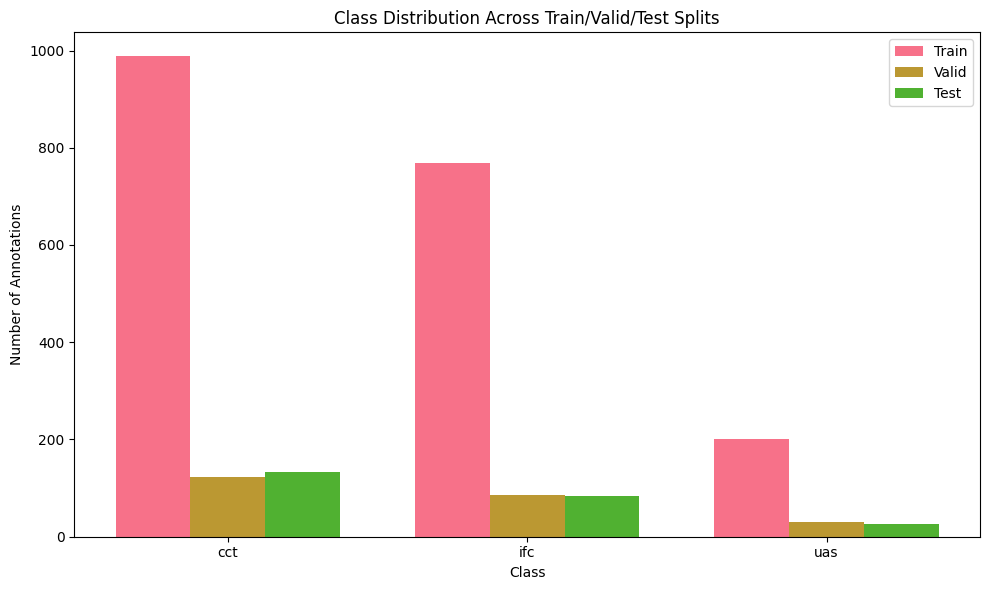

In [14]:
# Visualize split distribution
splits = ['train', 'valid', 'test']
x = np.arange(len(CLASS_NAMES))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

for i, split in enumerate(splits):
    values = [split_stats[split].get(cls_id, 0) for cls_id in range(NUM_CLASSES)]
    ax.bar(x + i*width, values, width, label=split.capitalize())

ax.set_xlabel('Class')
ax.set_ylabel('Number of Annotations')
ax.set_title('Class Distribution Across Train/Valid/Test Splits')
ax.set_xticks(x + width)
ax.set_xticklabels(CLASS_NAMES)
ax.legend()

plt.tight_layout()
plt.savefig('/kaggle/working/split_distribution.png' if IS_KAGGLE else 'split_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 7. 💾 Verify Output for Kaggle Dataset

In [15]:
# List all files created in /kaggle/working/
if IS_KAGGLE:
    print("="*60)
    print("📦 FILES SAVED TO /kaggle/working/ (Will be in output)")
    print("="*60)
    
    working_dir = Path('/kaggle/working')
    
    for item in working_dir.iterdir():
        if item.is_file():
            print(f"📄 {item.name} ({item.stat().st_size / 1024:.1f} KB)")
        elif item.is_dir():
            # Count files in subdirectories
            num_files = sum(1 for _ in item.rglob('*') if _.is_file())
            print(f"📁 {item.name}/ ({num_files} files)")
            
    # Detailed breakdown of dataset
    print("\n📊 Dataset Structure:")
    for split in ['train', 'valid', 'test']:
        split_dir = BASE_OUTPUT_DIR / split
        if split_dir.exists():
            num_images = len(list((split_dir / 'images').glob('*')))
            num_labels = len(list((split_dir / 'labels').glob('*')))
            print(f"   {split}: {num_images} images, {num_labels} labels")

print("\n" + "="*60)
print("✅ EDA AND DATA PREPARATION COMPLETE!")
print("="*60)

📦 FILES SAVED TO /kaggle/working/ (Will be in output)
📁 dataset/ (4526 files)
📄 __notebook__.ipynb (1534.8 KB)
📄 class_distribution.png (81.3 KB)
📄 sample_images.png (1765.9 KB)
📄 image_dimensions_analysis.png (54.0 KB)
📄 split_distribution.png (37.8 KB)
📄 data.yaml (0.1 KB)

📊 Dataset Structure:
   train: 1810 images, 1810 labels
   valid: 226 images, 226 labels
   test: 227 images, 227 labels

✅ EDA AND DATA PREPARATION COMPLETE!


---
## 📋 Next Steps for Kaggle

### Step 1: Save This Notebook
1. Click **"Save Version"** (top right)
2. Select **"Save & Run All (Commit)"**
3. Wait for execution to complete

### Step 2: Create a New Dataset from Output
1. Go to your notebook's **"Output"** tab
2. Click **"New Dataset"** button
3. Name it (e.g., `brain-mri-split-dataset`)
4. Click **"Create"**

### Step 3: Use in Other Notebooks
In notebooks 02, 03, 04, update the paths:

```python
# Add the new dataset as input, then use:
BASE_DIR = Path('/kaggle/input/brain-mri-split-dataset/dataset')
DATA_YAML = Path('/kaggle/input/brain-mri-split-dataset/data.yaml')
```

---

**🎉 You're all set!**